In [1]:
import obspy
import torch
import glob
import copy
import numpy as np
import earthquake_func
from obspy.taup import TauPyModel
from obspy.signal.cross_correlation import correlate
from obspy.geodetics.base import gps2dist_azimuth
from obspy.signal.rotate import rotate_ne_rt

tau_len = 15  # correlation shifting length - investigation depth
sampling_rate = 50  # resampling rate of data
dt = 1 / sampling_rate
shift = round(tau_len/dt)
tau = np.arange(shift+1) * dt

M = 1  # km

data_path = "/net/sb/data1/BASIN/SB1/TIMEdir50/"

In [2]:
# Earthquake information
event_time = 46 * 60 + 35  
source_depth_in_km = 38.0  
source_lat = -18.504  
source_lon = -70.576  

model = TauPyModel(model='iasp91') 

Distance in degree:  69.41874260334617


/tmp/ipykernel_1702932/3397436340.py:6: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  _, _, ba = gps2dist_azimuth(


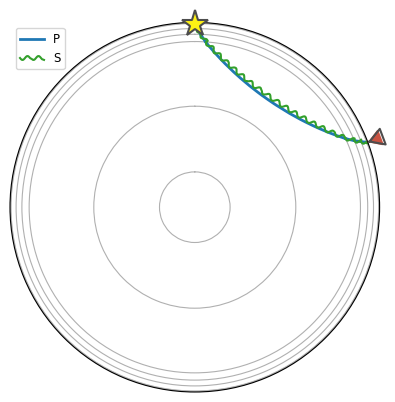

In [3]:
## Reference station
st = obspy.read(data_path+"2019120309/20191203090000.1002.BHZ.sac")
station_lat = st[0].stats.sac.stla
station_lon = st[0].stats.sac.stlo

_, _, ba = gps2dist_azimuth(
    source_lat, source_lon, station_lat, station_lon
)
distance_in_degree = obspy.geodetics.locations2degrees(source_lat, source_lon, station_lat, station_lon)
print('Distance in degree: ', distance_in_degree)
ray_paths = model.get_ray_paths(source_depth_in_km=source_depth_in_km, 
                                distance_in_degree=distance_in_degree,
                                phase_list=['P', 'S']
                                )
ray_paths.plot_rays(plot_type='spherical', legend=True, indicate_wave_type=True, plot_all=False, phase_list=['P', 'S'])
arrivals = model.get_travel_times(source_depth_in_km=source_depth_in_km,
                                  distance_in_degree=distance_in_degree)
arrivals = model.get_travel_times(source_depth_in_km=source_depth_in_km,
                                  distance_in_degree=distance_in_degree,
                                  phase_list=['P', 'S'])

In [4]:
all_data = glob.glob(data_path+"2019120309/20191203090000.*.BHE.sac") 
station_nums = [trace[-12:-8] for trace in all_data]
nsts = len(station_nums)
lats = []
lons = []

for num in station_nums:
    filename = data_path + "2019120309/20191203090000.{}.BHE.sac".format(num) 
    st = copy.deepcopy(obspy.read(filename)[0])
    lats.append(st.stats.sac.stla)
    lons.append(st.stats.sac.stlo)

station_nums = np.array(station_nums)
lats = torch.from_numpy(np.array(lats))  # (nstations,)
lons = torch.from_numpy(np.array(lons))  # (nstations,)
# Convert lats and longs to x (km)
xs = torch.zeros_like(lats)
ori = np.argmin(lons)  # from W to E
xs[ori] = 0 
for i in range(xs.size(0)):
    xs[i] = gps2dist_azimuth(lats[i], lons[i], lats[ori], lons[ori])[0] / 1000

assert xs[ori] == 0 

# rearrange the data following ascending 0rder of x
order = torch.argsort(xs)
xs = xs[order]
lats = lats[order]
lons = lons[order]
station_nums = station_nums[order]

/tmp/ipykernel_1702932/290230278.py:21: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  xs[i] = gps2dist_azimuth(lats[i], lons[i], lats[ori], lons[ori])[0] / 1000


In [5]:
ACF = torch.zeros(nsts, shift+1)

t0 = event_time + arrivals[1].time  ## S wave arrival
if t0 > 3600:  # next hour
    t0 = int(t0%3600) + 2

tlen = 20
t1 = t0 + tlen

flag = True
data = []
for i in range(len(station_nums)):
    filename = data_path + "2019120309/20191203090000.{}.BHN.sac".format(station_nums[i])  ##
    stn = copy.deepcopy(obspy.read(filename)[0])
    filename = data_path + "2019120309/20191203090000.{}.BHE.sac".format(station_nums[i])  ##
    ste = copy.deepcopy(obspy.read(filename)[0])
    
    # rotate ne to rt
    _, _, ba = gps2dist_azimuth(source_lat, source_lon, lats[i], lons[i])
    stn.data, ste.data = rotate_ne_rt(stn.data, ste.data, ba)
    
    # NMO time shift 
    distance_in_degree = obspy.geodetics.locations2degrees(source_lat, source_lon, lats[i], lons[i])
    arrivals = model.get_travel_times(source_depth_in_km=source_depth_in_km,
                                distance_in_degree=distance_in_degree, 
                                phase_list=['P', 'S'])
    phase_time = arrivals[1].time  ## S wave

    ste.stats.starttime -= phase_time
    
    if flag == True:
        starttime = ste.stats.starttime
        flag = False
    
    data_t = earthquake_func.data_preprocessing(ste, starttime, t0, t1)
    
    corr = correlate(data_t, data_t, shift=shift, demean=True, normalize='naive', method='fft')
    ACF[i] = torch.from_numpy(corr[shift:])
    
    data.append(data_t)
    
data = torch.from_numpy(np.array(data))

/tmp/ipykernel_1702932/193810601.py:19: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  _, _, ba = gps2dist_azimuth(source_lat, source_lon, lats[i], lons[i])


In [6]:
# stacking within M
ACF_stack = torch.zeros(nsts, shift+1)
nstack = np.zeros(nsts)
for i in range(nsts):
    for j in range(nsts):
        distM = gps2dist_azimuth(lats[i], lons[i], lats[j], lons[j])[0] / 1000
        if distM <= M:
            ACF_stack[i] += ACF[j]
            nstack[i] += 1

ACF_stack = ACF_stack / nstack.reshape(-1, 1)
ACF_stack = earthquake_func.normalize_by_trace(ACF_stack)

/tmp/ipykernel_1702932/2565909770.py:6: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  distM = gps2dist_azimuth(lats[i], lons[i], lats[j], lons[j])[0] / 1000


In [7]:
A_avr = ACF_stack.mean(dim=0)
R = ACF_stack - A_avr
R = earthquake_func.normalize_by_trace(R)

In [8]:
np.save("earthquake_acf_SB1_TT_M{}.npy".format(M), R)

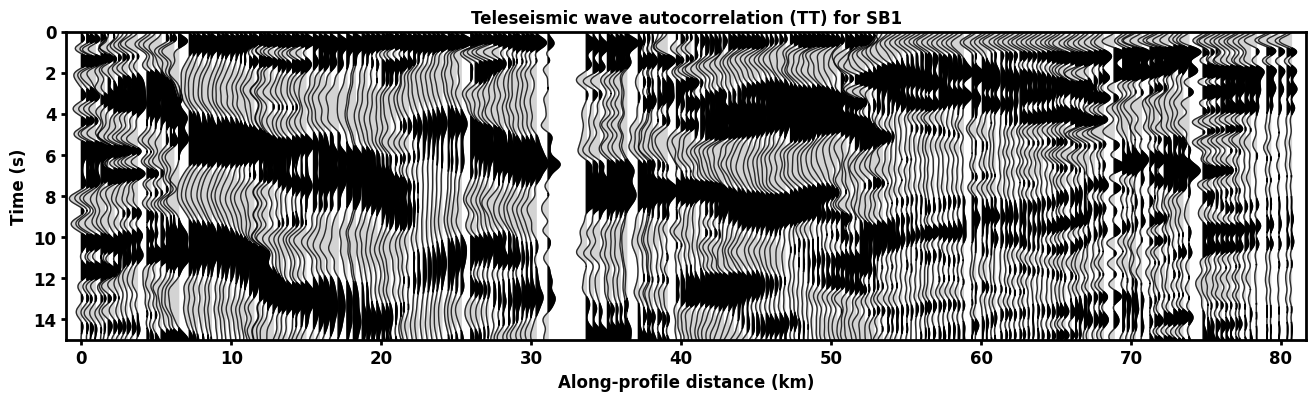

In [9]:
earthquake_func.section_plot(record=R, xs=xs, ts=tau, title="Teleseismic wave autocorrelation (TT) for SB1", 
                             scale=0.8, save=True, figname="teleseismic_example.png", fillcolors=('k', '#D3D3D3'), figsize=(16, 4))